# Training a custom regression model without Keras

Suggested reading:
* https://www.tensorflow.org/tutorials/customization/autodiff
* https://www.tensorflow.org/tutorials/customization/custom_training


## Our Model
Denote by $X$ the maximal daily temperature (in Celsius) at a given day and by $Y$ a number of ice-creams sold on that day. We want to model dependency of $Y$ on $X$. Consider the model 
$$ Y \sim \mathrm{Poisson}\big[rate=\mathrm{softplus(a X + b)}\big]$$
where $a, b\in \mathbb R$ are unknown constants. 

## Generate some artificial data
We assume $a = 0.1$; $b=4$ are the real values of the constants we want to find and we have 1000 observations. Thus our data consist of vectors `X`, `Y` of length 1000.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt
import numpy as np

First few elements of X: [ 15.110626    4.2292204  -4.1969495 -10.360373  -12.3682785]
First few elements of Y: [4. 4. 7. 3. 2.]


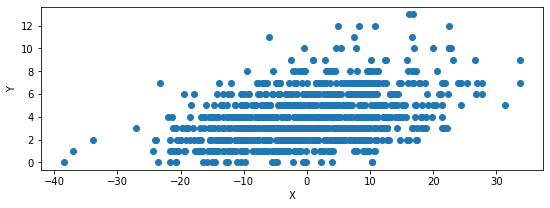

In [2]:
tf.random.set_seed(0)

X = tfd.Normal(0, 10).sample(1000)
print("First few elements of X:", X[:5].numpy())

rate = tf.nn.softplus(0.1 * X + 4)

Y = tfd.Poisson(rate).sample()
print("First few elements of Y:", Y[:5].numpy())

# plotting
plt.figure(figsize=[9, 3])
ax = plt.gca()
ax.scatter(X, Y)
ax.set_xlabel("X")
ax.set_ylabel("Y");

## Regression
We will find the parameters by maximizing the likelihood.

### Exercise 1
Write a function calculating the `loss` that is the negative log-likelihood of the parameters for given data. Make sure you use only `tensorflow` and `tensorflow-probability`, not `numpy` or `scipy`.

Hint: I would use the following functions: `tf.nn.softplus`, `tf.reduce_sum` and `log_prob` method of `tfd.Poisson`.  

In [3]:
def get_loss(a, b, X, Y):
    """ Return the negative log-likelihood of the params `a, b`. 
    
    Args:
        a, b: scalars; parameters of our model
        X: vector of measured daily temperatures
        Y: observed numbers of sold ice-creams on the corresponding days
        
    Returns:
        scalar `- log( P[Y | a, b, X] )`
    """
    # Your code here
    rate = tf.nn.softplus(a * X + b)
    distr = tfd.Poisson(rate)
    return - tf.reduce_sum(distr.log_prob(Y))

In [4]:
# a little test
l = get_loss(a=1., b=2., X=tf.constant([-10., 0., 10.]), Y=[1, 2, 3])
assert np.allclose(l, 15.648288)

In [5]:
# The current estimate of each parameter will be stored in a `tf.Variable`
# We initialize these variables with some arbitrary numbers.

a = tf.Variable(1, name="a", dtype=K.floatx())
b = tf.Variable(0, name="b", dtype=K.floatx())
weights = [a, b]

In [6]:
# Choose the `optimizer` to be used for minimization of the loss
optimizer = tf.optimizers.Adam()

### Exercise 2
In the following cell complete the inside of the optimization loop -- evaluate the current `loss` and use the `tf.GradientTape` to calculate the gradient with respect to the weights. Assign the gra

In [7]:
for step in range(10000):
    # calculate current loss and use `tf.GradientTape` to calculate loss gradients with respect to the `weights`
    with tf.GradientTape() as tape:
        loss = get_loss(a, b, X, Y)

    grads = tape.gradient(loss, weights)
    
    # using the `optimizer` we can use the calculated gradients to update the values of `weights`
    optimizer.apply_gradients(zip(grads, weights))

print(loss.numpy(), a.numpy(), b.numpy())

2078.1162 0.092318445 3.9703152


# Speed things up using `tf.function`
Try so read the "basics" part of the following tutorial:
https://www.tensorflow.org/tutorials/customization/performance

Using `tf.function` decorator often speeds the calculations a lot! (And sometimes not.) Unfortunately not all the code that works well in the eager-mode (un-decorated) compiles well to graph-mode (decorated). If you will use it, be prapared for some fight. 

### Exercise 3
Copy your `quadratic_fun` from the previous exercise. 
Use the `%%timeit` magic to measure the time we need to run it.
Then use `tf.function` decorator and measure the time again. Here the difference in speed will not be large.

In [8]:
def quadratic_fun(a, b, c, x):
    # Your code comes here
    return tf.reduce_sum((tf.linalg.matvec(a, x) + b) * x, axis = [-1]) + c

In [9]:
n = 5

In [10]:
%%timeit
quadratic_fun(a=tf.zeros([n, n]), b=tf.zeros(n), c=0, x=tf.ones([1000, n]));

402 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
f = tf.function(quadratic_fun)

In [12]:
%timeit f(a=tf.zeros([n, n]), b=tf.zeros(n), c=0, x=tf.ones([1000, n]));

473 µs ± 8.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Exercise 4
copy the content of the optimization for-loop in the first exercise into one function without arguments 
```python
def train_step():
    # your code here
```
Then use `%timeit` magic to see the difference in speed of the decorated and un-decorated versions.

In [15]:
def train_step():
    with tf.GradientTape() as tape:
        loss = get_loss(a, b, X, Y)

    grads = tape.gradient(loss, weights)
    
    # using the `optimizer` we can use the calculated gradients to update the values of `weights`
    optimizer.apply_gradients(zip(grads, weights))

In [16]:
%timeit train_step()

2.09 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
ts = tf.function(train_step)

In [18]:
%timeit ts

21.4 ns ± 4.14 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


### Technical Remark
Feel free to skip this.

Decorating by `tf.function` does not do much. The compilation to the computation-graph happens only when the decorated function is called for the first time. The `tensorflow` then knows what are the shapes of the incomming tensors and creates a graph whose inputs have the corresponding shapes. This compilation is quite time-consuming, but the good thing is that happens only once. 

Unless you call the decorated function with arguments of different shapes! In that case it happens again. Fortunately you can specify the input-shapes in advance, including not-completely defined shapes. The tensorflow then creates one graph whose imputs have partially defined shapes and uses this graph for all subsequent evaluations of the decorated function. To do this, you must specify the `input_signature` parameter of the `tf.function`.

As an example consider the case when we want to use our `quadratic_fun` only in 5-dimensional space and with 1-dimensional batches of vectors `x`. However the size of the batch is unknown in advance and can change.

In [19]:
n = 5
input_signature=[tf.TensorSpec([n, n], K.floatx()), 
                 tf.TensorSpec([n], K.floatx()), 
                 tf.TensorSpec([], K.floatx()), 
                 tf.TensorSpec([None, n], K.floatx())  # `x` has unknown batch-size
                ]

@tf.function(input_signature=input_signature)
def quadratic_fun__decorated(a, b, c, x):
    # Using Honza's calculation:
    return tf.reduce_sum((tf.linalg.matvec(a, x) + b) * x, axis = [-1]) + c

In [20]:
quadratic_fun__decorated(tf.zeros([5, 5]), tf.zeros([5]), 0., tf.zeros([2, 5]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [21]:
quadratic_fun__decorated(tf.zeros([5, 5]), tf.zeros([5]), 0., tf.zeros([3, 5]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [22]:
# The following evaluation now fails since the inputs are not consistent with the `input_signature`
quadratic_fun__decorated(tf.zeros([6, 6]), tf.zeros([6]), 0., tf.zeros([3, 6]))

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], shape=(6, 6), dtype=float32),
    tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32),
    0.0,
    tf.Tensor(
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], shape=(3, 6), dtype=float32))
  input_signature: (
    TensorSpec(shape=(5, 5), dtype=tf.float32, name=None),
    TensorSpec(shape=(5,), dtype=tf.float32, name=None),
    TensorSpec(shape=(), dtype=tf.float32, name=None),
    TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

# Optional reading - Datasets
Read first part "Basic Mechanics" of this tutorial:
https://www.tensorflow.org/guide/data#basic_mechanics

### Optional Exercise 5
Let's return to our ice-cream regression.
Imagine that we can't evaluate our model (because it is too complicated and we have too much data) at once and we want to use the stochastic-descent on mini-batches created from the data. 
* Use `tf.data.Dataset.from_tensor_slices` to create a dataset from our data tensors `X`, `Y`
* use `shuffle` and `batch` methods of the dataset to create a shuffled and batched dataset, say with batches of length 100.
* Write a new training loop where in each epoch you iterate through all the batches in the batched data-set and apply the gradient descent (or a fancier optimizer optimizer like adam) to each batch separately.